In [51]:
import json
import numpy as np
import xobjects as xo
import xtrack as xt
import xpart as xp
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy import constants 
####################
# Choose a context #
####################
# context = xo.ContextCpu()
# context = xo.ContextCpu(omp_num_threads='auto')
# buf = context.new_buffer()

# # Ion properties:
# m_u = 931.49410242e6 # eV/c^2 -- atomic mass unit
# A = 207.98 # Lead-208
# Z = 82  # Number of protons in the ion (Lead)
# Ne = 3 # Number of remaining electrons (Lithium-like)
# q0=Z-Ne
# m_e = 0.511e6 # eV/c^2 -- electron mass
# m_p = 938.272088e6 # eV/c^2 -- proton mass
# clight = 299792458.0 # m/s



# m_ion = A*m_u + Ne*m_e # eV/c^2
# equiv_proton_momentum = 236e9 # eV/c = gamma_p*m_p*v
# gamma_p = np.sqrt( 1 + (equiv_proton_momentum/m_p)**2 ) # equvalent gamma for protons in the ring

# p0c = equiv_proton_momentum*(q0) # eV/c
# gamma = np.sqrt( 1 + (p0c/m_ion)**2 ) # ion relativistic factor
# beta = np.sqrt(1-1/(gamma*gamma)) # ion beta


In [52]:

mass0=37.21*1e9 #eV/c**2
energy_mean=7.65*1e12 #eV
gamma0=energy_mean/mass0
beta0 = np.sqrt(1-1/(gamma0*gamma0)) # ion beta

clight = 299792458.0 # m/s

p0c=gamma0*mass0*beta0 #eV/c

A=40
Z=20
q0=17

mc = A*0.931e9 # eV/c useful for ions

gamma2 = np.sqrt( 1 + (p0c/mass0)**2 ) # ion relativistic factor verify

In [53]:
print('gamma',gamma0)
print('gamma2',gamma2)

gamma 205.5898951894652
gamma2 205.5898951894652


In [54]:
#%%
##################
# Build TrackJob #
##################

fname_sequence ='/home/pkruyt/cernbox/xsuite-env/xtrack/test_data/sps_w_spacecharge/line_no_spacecharge_and_particle.json'

with open(fname_sequence, 'r') as fid:
     input_data = json.load(fid)
SPS_line = xt.Line.from_dict(input_data['line'])

# SPS_line=xt.Line.from_json('SPS_2021_Pb_nominal.json')

# Build a reference particle
particle_sample = xp.Particles(mass0=mass0, q0=q0, p0c=p0c)
SPS_line.particle_ref = particle_sample
twiss = SPS_line.twiss(symplectify=True)

twiss_dict=dict(twiss)

#%%
###################
# Linear Transfer #
###################

qx=twiss['qx']
qy=twiss['qy']
dqx=twiss['dqx']
dqy=twiss['dqy']
circumference=twiss['s'][-1]
# beta_x=twiss['betx'][-1]
# beta_y=twiss['bety'][-1]

qs=twiss['qs']
bets=twiss['betz0']


#at interaction points: #from https://anaconda.org/petrenko/li_like_ca_in_sps/notebook
beta_x  =  54.614389 # m
beta_y  =  44.332517 # m
alpha_x = -1.535235
alpha_y =  1.314101



Dx  =  2.444732 # m
Dpx =  0.097522

Dx  =  0
Dpx =  0.00

Dy  =  0.0 # m
Dpy =  0.0

#index of gamma factory along SPS line: 16675

arc = xt.LineSegmentMap(
        qx=qx, qy=qy,
        dqx=0, dqy=0,
        length=circumference,
        alfx=alpha_x,
        alfy=alpha_y,
        betx=beta_x,
        bety=beta_y,
        
        dx=Dx,
        dpx=Dpx,
        dy=Dy,
        dpy=Dpy,
        qs=qs,
        bets=bets,
        )

T_per_turn = circumference/(clight*beta0)

Loading line from dict:   0%|          | 0/14704 [00:00<?, ?it/s]

Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [55]:
nemitt = 1.5e-6 # m*rad (normalized emittance)
emitt=nemitt/beta0*gamma0


In [56]:
Np=int(1e6)
n_part = int(1e3)

u  = np.random.normal(scale=np.sqrt(emitt), size=Np)
up = np.random.normal(scale=np.sqrt(emitt)/beta_x, size=Np)

x  = u*np.sqrt(beta_x) # m
px = up*np.sqrt(beta_x) - u*alpha_x/np.sqrt(beta_x) # rad

u  = np.random.normal(scale=np.sqrt(emitt), size=Np)
up = np.random.normal(scale=np.sqrt(emitt)/beta_y, size=Np)

y  = u*np.sqrt(beta_y) # m
py = up*np.sqrt(beta_y) - u*alpha_y/np.sqrt(beta_y) # rad



In [57]:
sigma_x = 0.80e-3 # m
sigma_y = 0.57e-3  # m
sigma_dp = 2e-4 # relative ion momentum spread

nemitt = 1.5e-6 # m*rad (normalized emittance)
sigma_z = 10*1e-2 # m

sigma_px=np.std(px)
sigma_py=np.std(py)

particles0 = xp.Particles(
     mass0 = mass0, # eV/c^2
     q0    = q0,
     p0c   = p0c, # eV
     x     = np.random.normal(scale=sigma_x, size=n_part),
     px    = np.random.normal(scale=sigma_px, size=n_part),
     y     = np.random.normal(scale=sigma_y, size=n_part),
     py    = np.random.normal(scale=sigma_py, size=n_part),
     zeta  = np.random.normal(scale=sigma_z, size=n_part),
     delta = np.random.normal(scale=sigma_dp, size=n_part)
        )


In [58]:
# particles0.x=0
# particles0.px=0
# particles0.y=0
# particles0.py=0

std_x= np.std(particles0.x)
std_px= np.std(particles0.px)
std_y= np.std(particles0.y)
std_py= np.std(particles0.py)
std_zeta= np.std(particles0.zeta)
std_delta= np.std(particles0.delta)

print(sigma_px*1e3)
print(std_px*1e3)
print(sigma_py*1e3)
print(std_py*1e3)

4.353685417266152
4.2443354705787035
4.352165028987953
4.380802072706714


In [59]:
##################
# Laser Cooler #
##################

#laser-ion beam collision angle
theta_l = 1.3*np.pi/180 # rad
nx = 0; ny = -np.sin(theta_l); nz = -np.cos(theta_l)

# Ion excitation energy:
hw0 = 661.89 # eV
hc=constants.hbar*clight/constants.e # eV*m (ħc)
lambda_0 = 2*np.pi*hc/hw0 # m -- ion excitation wavelength

ion_excited_lifetime=0.4279*1e-12
lambda_l = lambda_0*gamma0*(1 + beta0*np.cos(theta_l)) # m -- laser wavelength

# Shift laser wavelength for fast longitudinal cooling:5
# lambda_l = lambda_l*(1+1*sigma_dp) # m

laser_frequency = clight/lambda_l # Hz
sigma_w = 2*np.pi*laser_frequency*sigma_dp
# sigma_w = 2*np.pi*laser_frequency*sigma_dp/2 # for fast longitudinal cooling

sigma_t = 1/sigma_w # sec -- Fourier-limited laser pulse
print('Laser pulse duration sigma_t = %.2f ps' % (sigma_t/1e-12))
print('Laser wavelength = %.2f nm' % (lambda_l/1e-9))

laser_waist_radius = 3.0e-3 #m
laser_energy = 2e-3

laser_x=1.4*1e-3 #Alexey

laser_x=10*1e-3

GF_IP = xt.PulsedLaser(
                laser_x=laser_x,
                laser_y=0,
                laser_z=0,
                
                laser_direction_nx = 0,
                laser_direction_ny = ny,
                laser_direction_nz = nz,
                laser_energy         = laser_energy, # J
                laser_duration_sigma = sigma_t, # sec
                laser_wavelength = lambda_l, # m
                laser_waist_radius = laser_waist_radius, # m
                laser_waist_shift = 0, # m
                ion_excitation_energy = hw0, # eV
                ion_excited_lifetime  = ion_excited_lifetime, # sec                   
                )

# simulation parameters: simulate 10 s of cooling, and take data once every 100 ms
max_time_s = 10
int_time_s = 0.1
T_per_turn = circumference/(clight*beta0)
num_turns = int(max_time_s/T_per_turn)
save_interval = int(int_time_s/T_per_turn)

# num_turns = int(1e3)
# save_interval = num_turns/100
# save_interval=1

# create a monitor object, to reduce holded data
monitor = xt.ParticlesMonitor(start_at_turn=0, stop_at_turn=1,
                              n_repetitions=int(num_turns/save_interval),
                              repetition_period=save_interval,
                              num_particles=n_part)

   
line = xt.Line(
        elements=[monitor,GF_IP,arc])

# line = xt.Line(
#         elements=[monitor,arc])

line.particle_ref = xp.Particles(mass0=mass0, q0=q0, p0c=p0c)

context = xo.ContextCpu(omp_num_threads=4)
line.build_tracker(_context=context)


Laser pulse duration sigma_t = 2.04 ps
Laser wavelength = 770.11 nm
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [60]:
# transverse_kick=hw0/p0c
# longitudinal_energy_loss_max = hw0*2*gamma0
# longitudinal_kick = longitudinal_energy_loss_max/p0c
# longitudinal_kick

In [61]:
# from statisticalEmittance import statisticalEmittance
#from statistical_emittance import statisticalEmittance
import statisticalEmittance



r=statisticalEmittance.StatisticalEmittance()

#StatisticalEmittance : Provide distribution in [set_particles]


In [62]:
particles=particles0.copy()

line.track(particles, num_turns=num_turns,
              turn_by_turn_monitor=False,with_progress=True)

epsn_x = []
epsn_y = []

# for ii in tqdm(range(num_turns)):
#     line.track(particles)
#     bunch_moments=r.measure_bunch_moments(particles)
#     epsn_x.append(bunch_moments['nemitt_x'])
#     epsn_y.append(bunch_moments['nemitt_y'])



bunch_moments=r.measure_bunch_moments(particles0)
epsn_x.append(bunch_moments['nemitt_x'])
epsn_y.append(bunch_moments['nemitt_y'])

print('epsn_x = ',epsn_x)
print('epsn_y = ',epsn_y)    



# extract relevant values
x = monitor.x[:,:,0]
px = monitor.px[:,:,0]
y = monitor.y[:,:,0]
py = monitor.py[:,:,0]
delta = monitor.delta[:,:,0]
zeta = monitor.zeta[:,:,0]
state = monitor.state[:,:,0]
time = monitor.at_turn[:, 0, 0] * T_per_turn


gamma_x=(1+alpha_x**2)/beta_x
gamma_y=(1+alpha_y**2)/beta_y

# compute actions. for x, remove the dp/p contribution:
# action_x = ((x-Dx*delta)**2/beta_x + beta_x*(px-Dpx*delta)**2)
action_x = (gamma_x*(x-Dx*delta)**2 + 2*alpha_x*(x-Dx*delta)*(px-Dpx*delta)+ beta_x*(px-Dpx*delta)**2)
# for y, simple compute:
# action_y = (y**2/beta_y + beta_y*py**2)
action_y = (gamma_y*(y-Dy*delta)**2 + 2*alpha_y*(y-Dy*delta)*(py-Dpy*delta)+ beta_y*(py-Dpy*delta)**2)


np.savez('results/Pulsed_data.npz', x=x, px=px, y=y, py=py, zeta=zeta, delta=delta,action_x=action_x,action_y=action_y, state=state, time=time,s_per_turn=T_per_turn)

Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

epsn_x =  [0.0007025482886630382]
epsn_y =  [0.0005339774726826148]


In [63]:
# plt.figure(figsize=(12, 8))
# plt.rcParams.update({'font.size': 25})
# plt.plot(epsn_x)
# plt.xlabel('time [s]')
# plt.ylabel('emittance x ')
# plt.title('emittance foteini')
# ax = plt.gca()
# # Removing the offset from the y-axis tick labels
# ax.yaxis.get_major_formatter().set_useOffset(False)
# # plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
# plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
# plt.show()

In [64]:
x[:,:].shape #(100, 1000)

x[0,:].shape



(1000,)

In [65]:
def emittance_2d_list(x, px,delta):
    emittances = []
    for i in range(x.shape[0]):  # Iterate over each turn
        
        data = np.array([x[i,:]-delta[i,:]*Dx, px[i,:]-delta[i,:]*Dpx])
        covMatrix = np.cov(data)
        determinant = np.sqrt(np.linalg.det(covMatrix)) #* beta0 * gamma0
        emittances.append(determinant)
    return emittances

def emittance_2d(x_data, px_data,delta_data):
    emittances = []
    for i in range(x_data.shape[0]):  # Iterate over each turn
        x=x_data[i,:]
        px=px_data[i,:]
        delta=delta_data[i,:]

        x=x-delta*Dx
        px=px-delta*Dpx
        
        emitt_RMS=np.sqrt(np.mean(x*x)*np.mean(px*px) - np.mean(x*px)*np.mean(x*px))
        emitt_RMS_n=emitt_RMS*gamma0  
        emittances.append(emitt_RMS)
        
    return emittances

emittance_x=emittance_2d(x,px,delta)
# emittance_y=emittance_2d(y,py,delta)

emittance_list=emittance_2d_list(x,px,delta)
# emittance_list

geometrical emittance inital: 0.0003083884908881465
------------------------------------------------------
emittance action averaging: 0.0009843377405658001
emittance statistical     : 3.424149366775857e-06
emittance covariance      : 3.42670784350849e-06
------------------------------------------------------
normalised emittance                 : 1.5e-06
normalised emittance action averaging: 0.20236989291395785
normalised emittance statistical     : 0.0007039705094285221
normalised emittance covariance      : 0.0007044965063918287


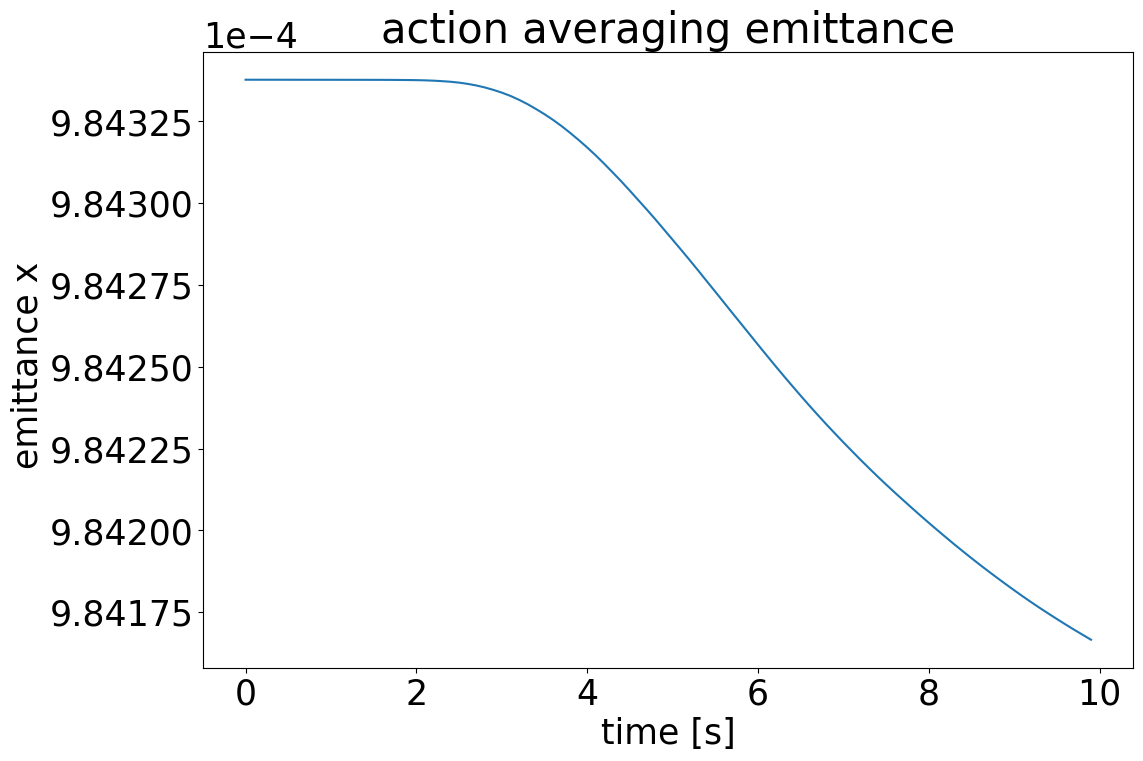

In [66]:
emittance_x_twiss=np.mean(action_x,axis=1)
print('geometrical emittance inital:',emitt)
print('------------------------------------------------------')
print('emittance action averaging:',emittance_x_twiss[0])
print('emittance statistical     :',emittance_x[0])
print('emittance covariance      :', emittance_list[0])
print('------------------------------------------------------')
print('normalised emittance                 :',nemitt)
print('normalised emittance action averaging:',emittance_x_twiss[0]*gamma0)
print('normalised emittance statistical     :',emittance_x[0]*gamma0)
print('normalised emittance covariance      :', emittance_list[0]*gamma0)


plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': 25})
plt.plot(time,emittance_x_twiss)
plt.xlabel('time [s]')
plt.ylabel('emittance x ')
plt.title('action averaging emittance')
ax = plt.gca()
# Removing the offset from the y-axis tick labels
ax.yaxis.get_major_formatter().set_useOffset(False)
# plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.show()

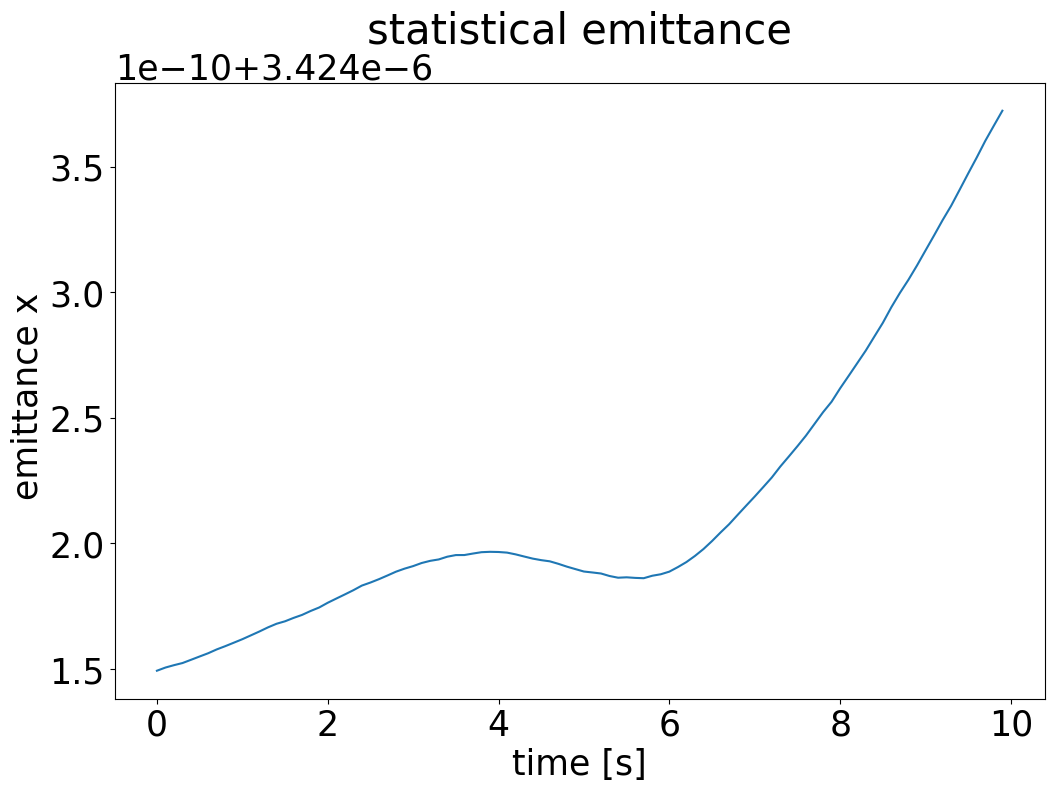

In [67]:
plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': 25})
plt.plot(time,emittance_x)
plt.title('statistical emittance')
plt.xlabel('time [s]')
plt.ylabel('emittance x ')
# plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.show()

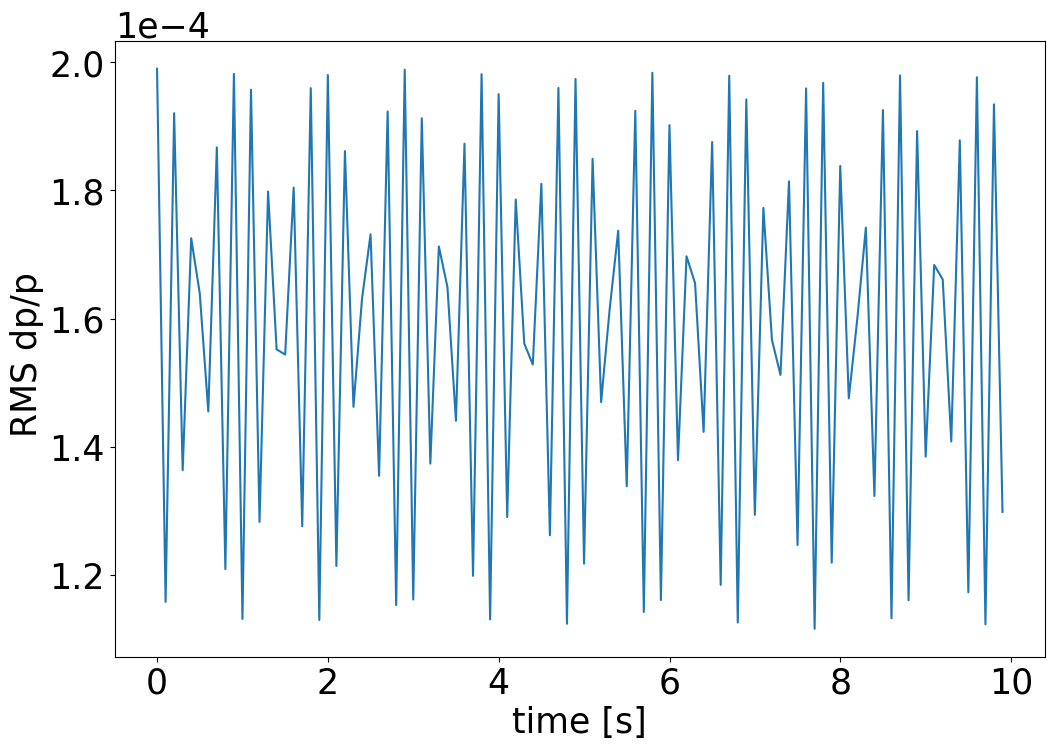

In [68]:
rms_dp=np.std(delta,axis=1)

plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': 25})
plt.plot(time,rms_dp)
plt.xlabel('time [s]')
plt.ylabel('RMS dp/p ')
# plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.show()

In [69]:
# def emittance_6d(part):
    
#     x=part.x
#     px=part.px
#     y=part.y
#     py=part.py
#     zeta=part.zeta    
#     delta=part.delta
    
#     #num_turns=part.num_turns
    
#     data = np.array([x,px,
#                      y,py,
#                      zeta,delta])
#     #data2=data
#     # if len(part.x)>Nions:
#     #     data2=data[:,1:]
#     # else: data2=data
    
#     covMatrix = (np.cov(data))
    
#     determinant = np.sqrt(np.linalg.det(covMatrix))*part.beta0[0]*part.gamma0[0]            
   

#     return determinant

# def emittance_2d_x(part):
    
#     x=part.x
#     px=part.px
#     y=part.y
#     py=part.py
#     zeta=part.zeta    
#     delta=part.delta
    
#     #num_turns=part.num_turns
    
#     data = np.array([x,px])
#     #data2=data
#     # if len(part.x)>Nions:
#     #     data2=data[:,1:]
#     # else: data2=data
    
#     covMatrix = (np.cov(data))
    
#     determinant = np.sqrt(np.linalg.det(covMatrix))*part.beta0[0]*part.gamma0[0]            
   

#     return determinant

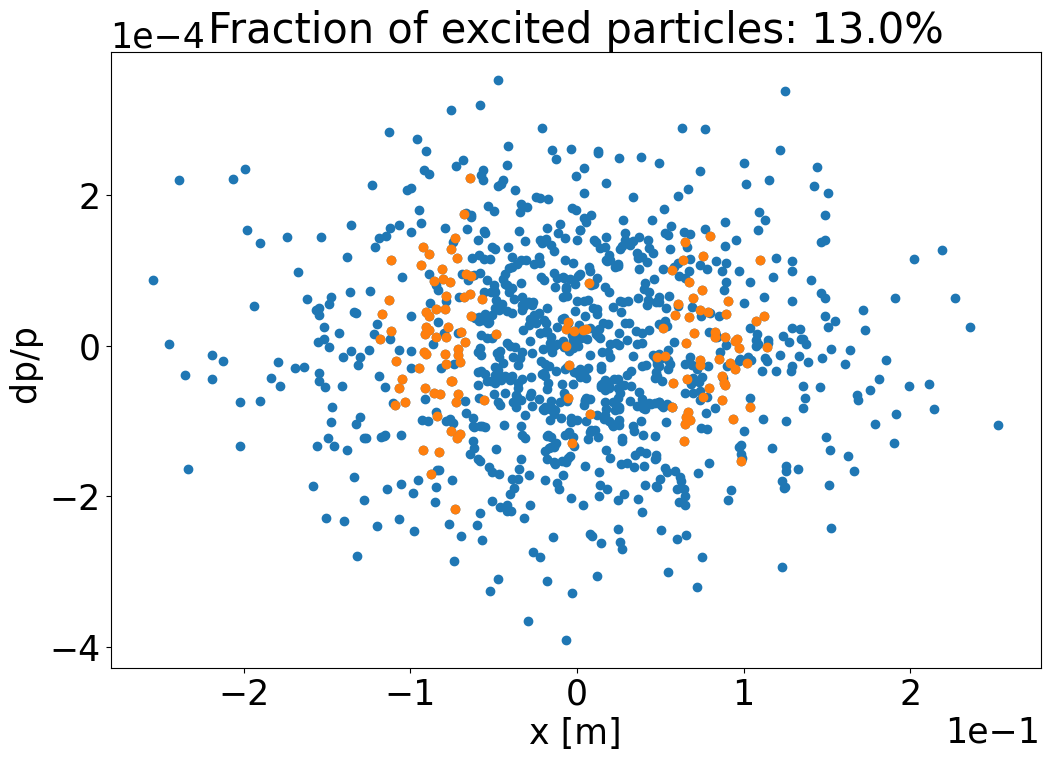

In [70]:
excited=particles.state==2

fraction_excitation = sum(excited)/len(excited)

plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': 25})
plt.title(f'Fraction of excited particles: {fraction_excitation*100:.3}%')
plt.scatter(particles.x,particles.delta)
plt.scatter(particles.x[excited],particles.delta[excited])
plt.xlabel('x [m]')
plt.ylabel('dp/p ')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.show()

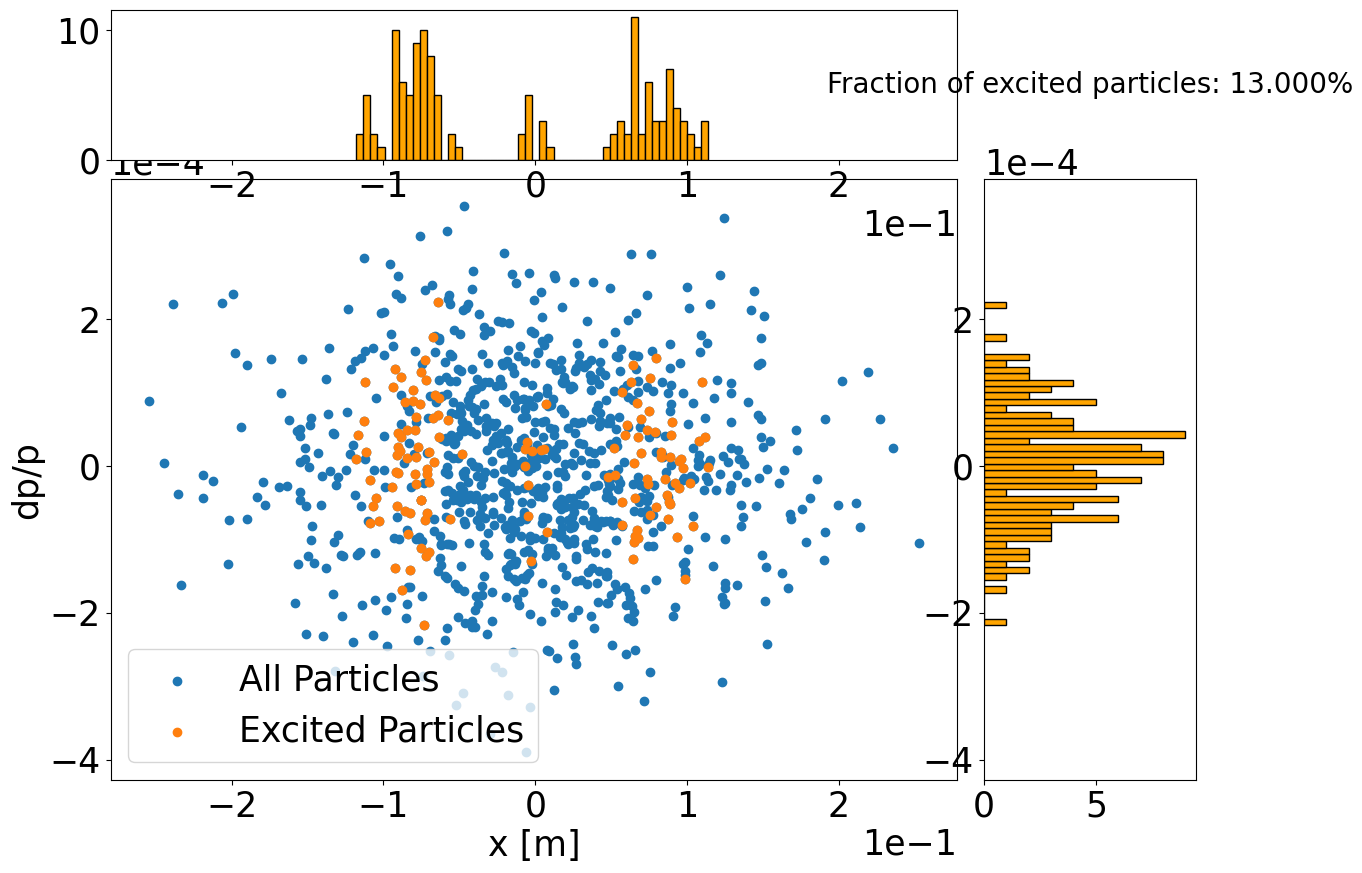

In [71]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Assuming you have particles and excited defined somewhere in your code
# excited = particles.state == 2
# fraction_excitation = sum(excited) / len(excited)

# Create a 2x2 grid layout
fig = plt.figure(figsize=(14, 10))
gs = GridSpec(2, 2, width_ratios=[4, 1], height_ratios=[1, 4], hspace=0.05, wspace=0.05)

# Scatter plot
ax_main = fig.add_subplot(gs[1, 0])
ax_main.scatter(particles.x, particles.delta, label='All Particles')
ax_main.scatter(particles.x[excited], particles.delta[excited], label='Excited Particles')
ax_main.set_xlabel('x [m]')
ax_main.set_ylabel('dp/p')
ax_main.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
ax_main.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
ax_main.legend()

# Histogram on the right
ax_right = fig.add_subplot(gs[1, 1], sharey=ax_main)
#ax_right.hist(particles.delta, bins=50, orientation='horizontal', color='lightblue', edgecolor='black')
ax_right.hist(particles.delta[excited], bins=50, orientation='horizontal', color='orange', edgecolor='black')

# Histogram on the top
ax_top = fig.add_subplot(gs[0, 0], sharex=ax_main)
#ax_top.hist(particles.x, bins=50, color='lightblue', edgecolor='black')
ax_top.hist(particles.x[excited], bins=50, color='orange', edgecolor='black')

# Title with the fraction of excited particles
title_ax = fig.add_subplot(gs[0, 1])
title_ax.set_axis_off()
title_ax.text(0.5, 0.5, f'Fraction of excited particles: {fraction_excitation * 100:.3f}%', ha='center', va='center', fontsize=20)

plt.show()


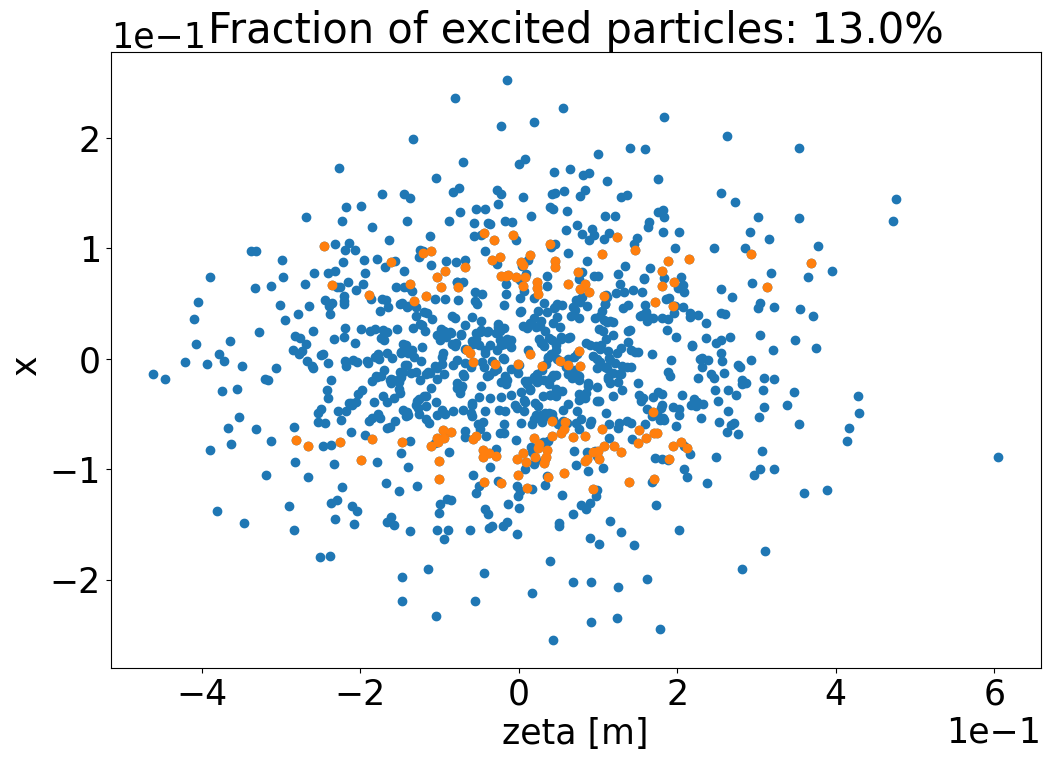

In [72]:
excited=particles.state==2

fraction_excitation = sum(excited)/len(excited)

plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': 25})
plt.title(f'Fraction of excited particles: {fraction_excitation*100:.3}%')
plt.scatter(particles.zeta,particles.x)
plt.scatter(particles.zeta[excited],particles.x[excited])
plt.xlabel('zeta [m]')
plt.ylabel('x ')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.show()

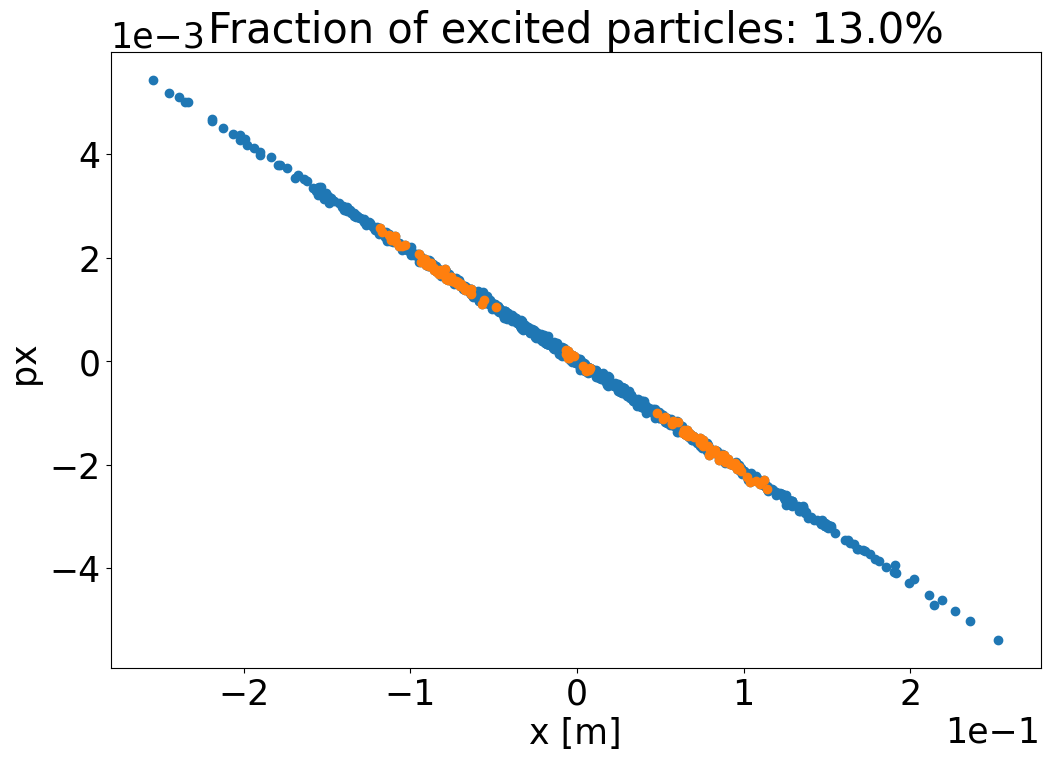

In [73]:
excited=particles.state==2

fraction_excitation = sum(excited)/len(excited)

plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': 25})
plt.title(f'Fraction of excited particles: {fraction_excitation*100:.3}%')
plt.scatter(particles.x,particles.px)
plt.scatter(particles.x[excited],particles.px[excited])
plt.xlabel('x [m]')
plt.ylabel('px ')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.show()